In [4]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
from scipy.spatial.distance import cdist

import anndata as ad
import pandas as pd
import sys

module_pth = "/home/alma/w-projects/ccf/src"
if module_pth not in sys.path:
    sys.path.append(module_pth)
    

import preprocess as pp

import os.path as osp
import os
from PIL import Image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from matplotlib import rcParams
rcParams["figure.facecolor"] = "white"

In [6]:
TRI_REF_DIR = "/home/alma/w-projects/ccf/rsc/ref/tri"
TRI_CNT_DIR = "/home/alma/w-projects/ccf/data/ludlar-triangle/curated"

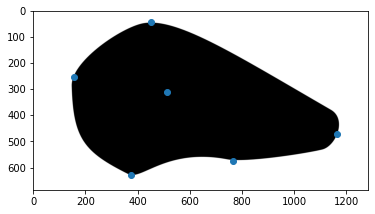

In [7]:
ref_img = Image.open(osp.join(TRI_REF_DIR,"tri.png"))
ref_lmk = pd.read_csv(osp.join(TRI_REF_DIR,"tri_reference_landmarks.tsv"),sep="\t",header = 0,index_col=0)

plt.imshow(ref_img)
plt.scatter(ref_lmk.x_cord,ref_lmk.y_cord)


In [8]:
grid_crd,_ = pp.reference_to_grid(ref_img,n_approx_points=1000)

[0 2]


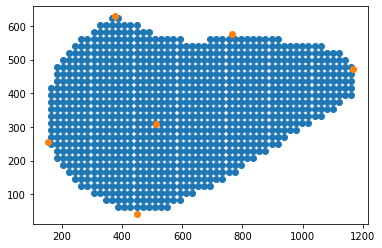

In [9]:
plt.scatter(grid_crd[:,0],grid_crd[:,1])
plt.scatter(ref_lmk.x_cord,ref_lmk.y_cord)


In [11]:
import models as m
import methods as f
import gpytorch as gp

ref = m.Reference(grid_crd,
                  landmarks = ref_lmk.values,
                 )

/home/alma/w-projects/ccf/src/models.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.landmarks = t.tensor(landmarks)


In [12]:
pths = os.listdir(TRI_CNT_DIR)
adatas = [ad.read_h5ad(osp.join(TRI_CNT_DIR,p)) for p in pths]

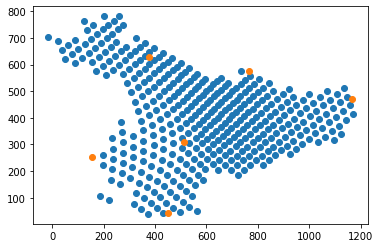

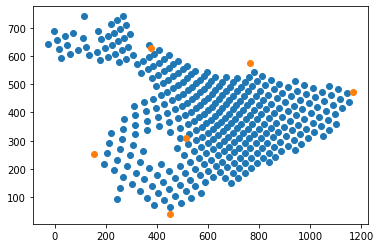

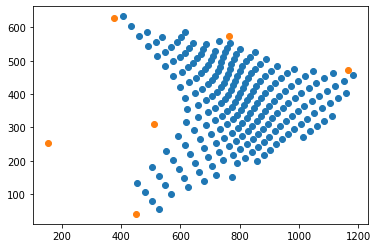

/home/alma/.local/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:182: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


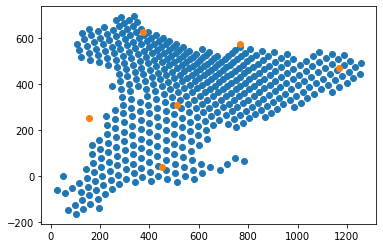

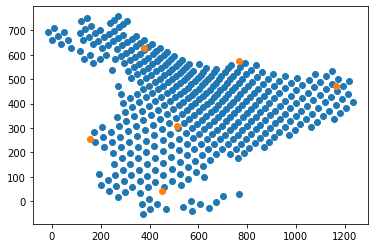

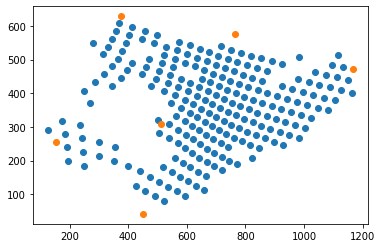

In [14]:
#pp.normalize_jointly(adatas)
for adata in adatas[0:-1]:
    sc.pp.filter_genes(adata,min_cells = 0.1)
    sc.pp.normalize_total(adata,1e4,exclude_highly_expressed = True)
    sc.pp.log1p(adata)
    sc.pp.scale(adata)
    pp.match_scales(adata,ref_lmk.values)
    pp.get_landmark_distance(adata,
                             reference=ref_lmk.values)    



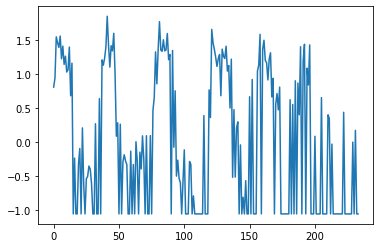

In [15]:
plt.plot(adata.obs_vector("CCN2"))

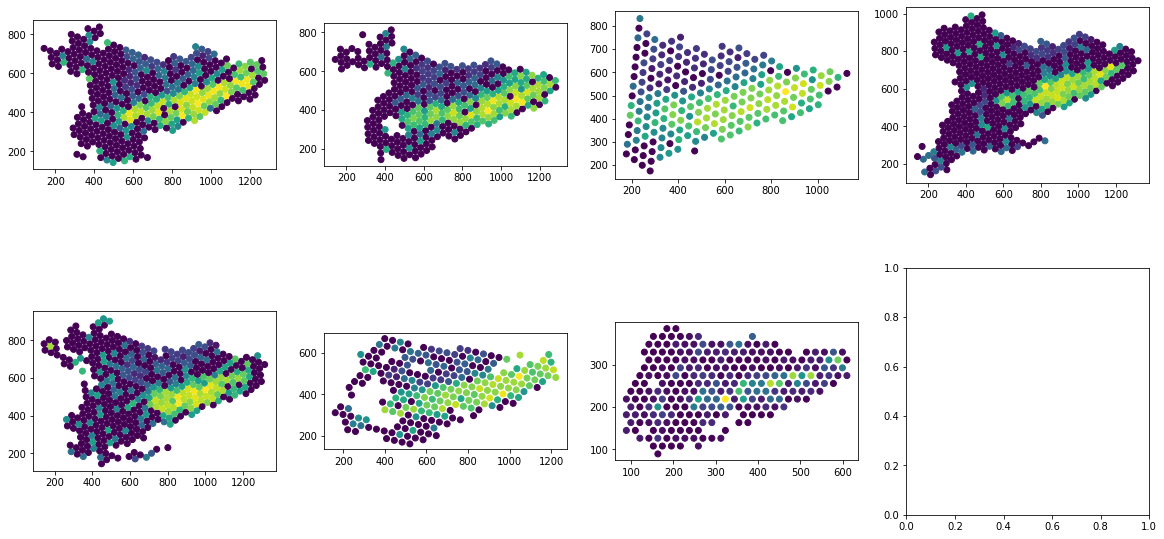

In [16]:
gene = "CCN2"
fig,ax = plt.subplots(2,4,figsize = (20,10))
ax = ax.flatten()
#mn = min([a.obs_vector(gene).min() for a in adatas])
#mx = max([a.obs_vector(gene).max() for a in adatas])
for k,adata in enumerate(adatas):
    ax[k].scatter(adata.obsm["spatial"][:,0],
                adata.obsm["spatial"][:,1],
                c = adata.obs_vector(gene))
    ax[k].set_aspect("equal")


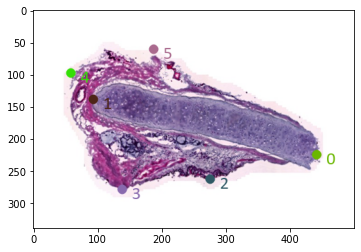

In [17]:
plt.imshow(adatas[-1].uns["spatial"]["section_1"]["images"]["hires_landmarks"])

In [18]:
models = f.map_to_reference(adatas[0:-1],
                            gene,
                            ref,
                            n_epochs=1000,
                           )

/home/alma/.local/lib/python3.7/site-packages/torch/autograd/__init__.py:147: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  allow_unreachable=True, accumulate_grad=True)  # allow_unreachable flag


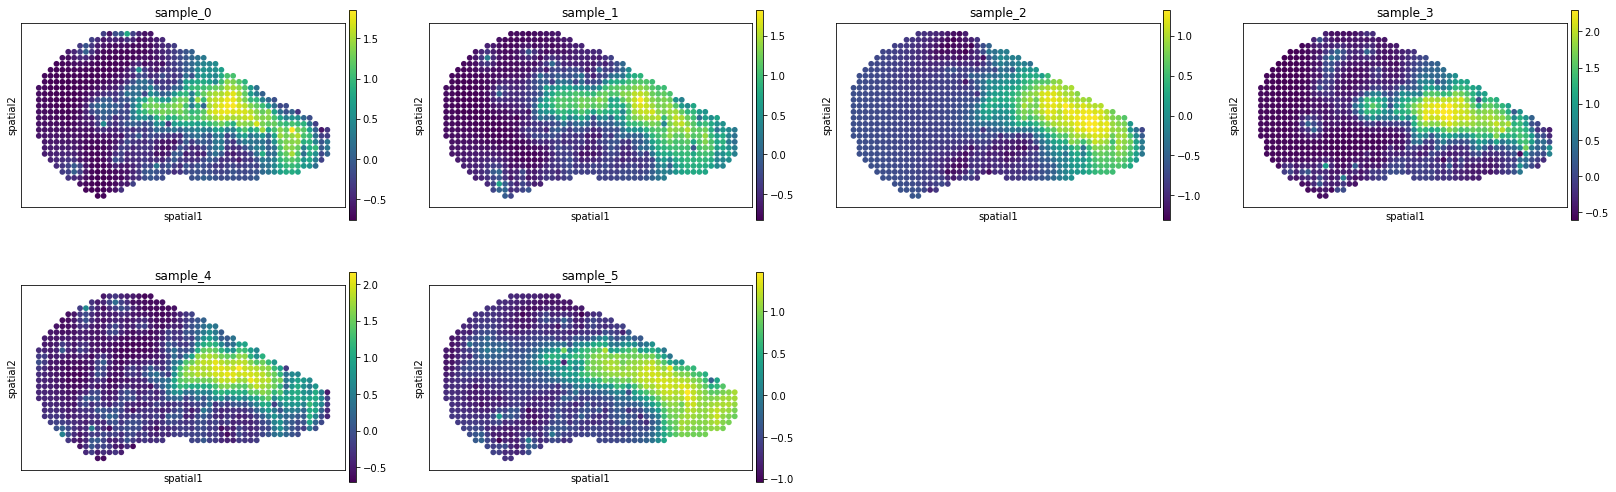

In [19]:
ref.plot(spot_size=20)#,ncols = 5)

In [51]:
import utils as ut

ut.spatial_smoothing(ref.adata,sigma = 50,n_neigh=9)

In [33]:
ref.adata

AnnData object with n_obs × n_vars = 941 × 6
    uns: 'spatial_neighbors'
    obsm: 'spatial'
    layers: 'smoothed'
    obsp: 'spatial_connectivities', 'spatial_distances'

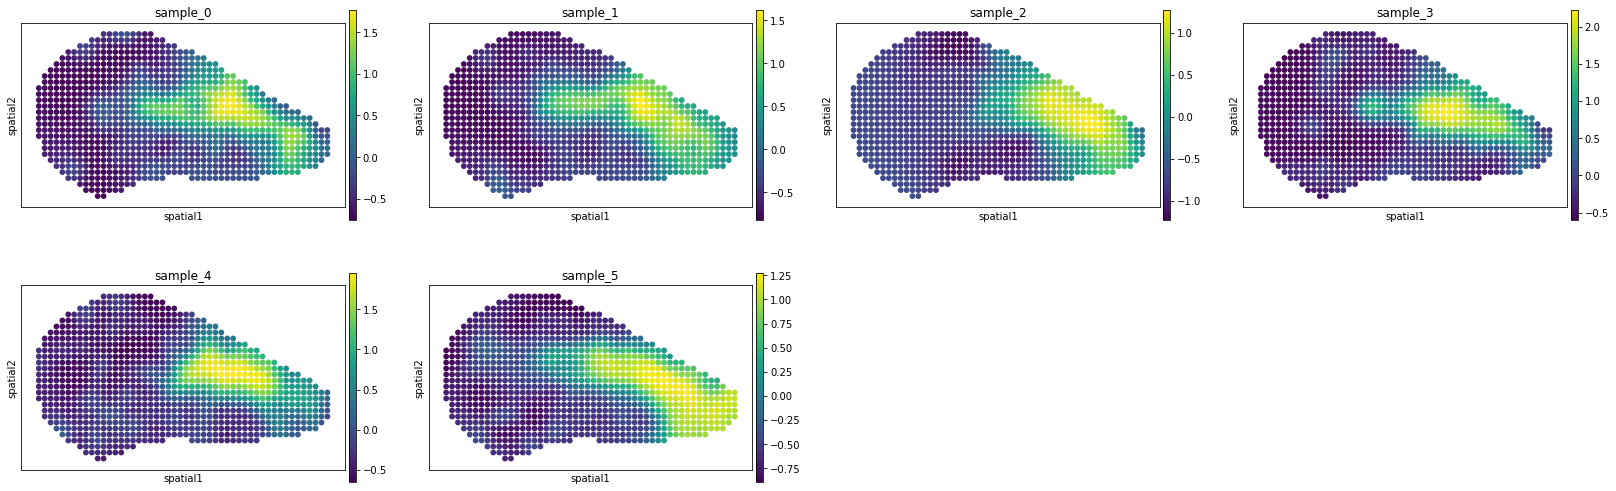

In [52]:
ref.plot(spot_size=20,layer = "smoothed")#,ncols = 5)

In [55]:
crd_1,expr_1 = ref.get_sample(0,layer = "smoothed")
crd_2,expr_2 = ref.get_sample(4,layer = "smoothed")

In [56]:
np.sum(expr_1 < 0)

590

In [57]:
lfc2 = np.log2((np.exp(expr_1) / (np.exp(expr_2))))

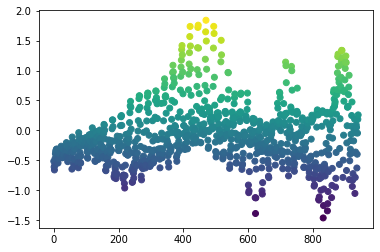

In [58]:
plt.scatter(np.arange(len(lfc2)),lfc2,c=lfc2)

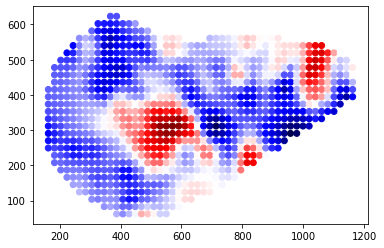

In [59]:
plt.scatter(crd_1[:,0],crd_1[:,1],c= lfc2,cmap = plt.cm.seismic)

In [ ]:
adatas[0].obs_vector("CNN2")